In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as torch_F
from jetbotData import get_train_val_dataloader
from torch import optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
# load the efficientNet 0
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)


Using cache found in /home/rita/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/rita/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/rita/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [3]:
# get the model's layer
# for name,parm in model.named_parameters():
#     print(name)

module_block=[]
for name,module in model.named_children():
    if name=="layers":
        for n,m in module.named_children():
            module_block.append(m)
            # print(m)

print(module_block)


[Sequential(
  (block0): MBConvBlock(
    (depsep): Sequential(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (se): SequentialSqueezeAndExcitation(
      (squeeze): Linear(in_features=32, out_features=8, bias=True)
      (expand): Linear(in_features=8, out_features=32, bias=True)
      (activation): SiLU(inplace=True)
      (sigmoid): Sigmoid()
      (mul_a_quantizer): Identity()
      (mul_b_quantizer): Identity()
    )
    (proj): Sequential(
      (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    )
    (residual_quantizer): Identity()
  )
), Sequential(
  (block0): MBConvBlock(
    (expand): Sequential(
      (conv): Conv2d(16, 96, kernel_size=(1, 

In [4]:

class SegmentUNet(nn.Module):
    def __init__(self):
        super(SegmentUNet, self).__init__()
        # init the project 
        self.Project_Encoder=nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        # encoder 
        self.Ecoder0 = module_block[0]
        self.Ecoder1 = module_block[1]
        self.Ecoder2 = module_block[2]
        self.Ecoder3 = module_block[3]
        # freeze the Ecoder
        self.Ecoder0.requires_grad=False
        self.Ecoder1.requires_grad=False
        self.Ecoder2.requires_grad=False
        self.Ecoder3.requires_grad=False
        
        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(80, 80, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(80, 80, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        
        # decoder 
        self.upDecoder0 = nn.ConvTranspose2d(80, 40, kernel_size=3, stride=5, padding=2)
        self.Decoder0 = nn.Sequential(
            nn.Conv2d(40, 40, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(40, 40, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.upDecoder1 = nn.ConvTranspose2d(40, 24, kernel_size=4, stride=4, padding=0)
        self.Decoder1 = nn.Sequential(
            nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.upDecoder2 = nn.ConvTranspose2d(24, 16, kernel_size=4, stride=4, padding=0)
        self.Decoder2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        # classifier head
        self.classifier = nn.Conv2d(32, 4, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        '''
        x : input # [B , 3 , 224 , 224]
        
        '''
        # project
        x=self.Project_Encoder(x) # [B , 32 , 224 , 224]
        # encoder 
        E0=self.Ecoder0(x) # [B , 16 , 224 , 224]
        # print(E0.shape)
        down_E0=torch_F.max_pool2d(E0,2)  # [B , 16 , 112 , 112]
        # print(down_E0.shape)
        E1=self.Ecoder1(down_E0) # [B , 24 , 56 , 56]
        # print(E1.shape)
        down_E1=torch_F.max_pool2d(E1,2) # [B , 24 , 28 , 28]
        # print(down_E1.shape)
        E2=self.Ecoder2(down_E1) # [B , 40 , 14 , 14]
        # print(E2.shape)
        down_E2=torch_F.max_pool2d(E2,2) # [B , 40 , 7 , 7]
        # print(down_E2.shape)
        E3=self.Ecoder3(down_E2) # [B , 80 , 4 ,4]
        # print(E3.shape)    
        
        mid_feat=self.bottleneck(E3) # [B , 80 , 4 ,4]
        # print("Decoder")
        # Decoer
        up_D0=self.upDecoder0(mid_feat) # [B , 40 , 7,7]
        # print(up_D0.shape)
        D1=self.Decoder0(up_D0+E2) # [B , 40 , 14,14]
        # print(D1.shape)
        up_D2=self.upDecoder1(D1)  # [B , 40 , 56,56]
        # print(up_D2.shape)
        D2=self.Decoder1(up_D2+E1)  # [B , 24 , 56,56]
        # print(D2.shape)             
        up_D3=self.upDecoder2(D2)  # [B , 16 ,224,224]
        # print(up_D3.shape)
        D3=self.Decoder2(up_D3+E0) # [B , 32 ,224,224]
        # print(D3.shape)
        out=self.classifier(D3) # [B , 4 ,224,224]
        return out

In [5]:
m=SegmentUNet().cuda()
x=torch.randn(1,3,224,224).cuda()
y=m(x)
y.shape

/home/rita/anaconda3/envs/DM/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


torch.Size([1, 4, 224, 224])

## Train RoadLane Dataset

dataset size: {'train': 2, 'val': 1}


  0%|          | 0/300 [00:00<?, ?it/s]

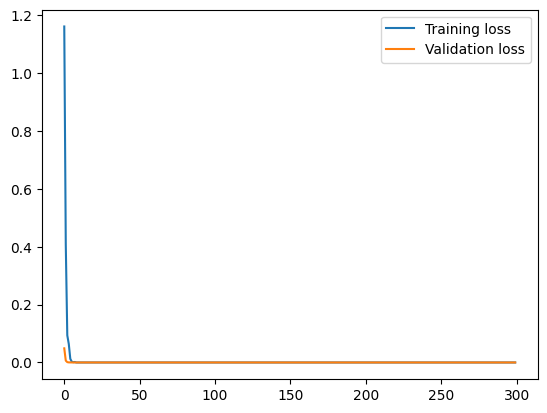

In [7]:
device = 'cuda'
epochs = 300
dataset_name = "roadlane"
dataloaders, dataset_size = get_train_val_dataloader(2,0, type=dataset_name)
save_dir = f'checkpoints/{dataset_name}/'
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(m.parameters(), lr=0.001)

train_dataloader = dataloaders["train"]
val_dataloader = dataloaders["val"]

print("dataset size:", dataset_size)

# TODO training loop
min_val_loss = float('inf')
train_loss = []
val_loss = []

for epoch in tqdm(range(epochs)):
    m.train()
    running_loss = 0.0
    for iter, batch in enumerate(train_dataloader):
        images = batch['img'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = m(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_train_loss  = running_loss / len(train_dataloader)

    m.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_batch in val_dataloader:
            X_val = val_batch["img"].to(device)
            y_val = val_batch["label"].to(device)
            outputs_val = m(X_val)
            running_val_loss += criterion(outputs_val, y_val).item()
    avg_val_loss = running_val_loss / len(val_dataloader)

    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_dir+'checkpoint.pth')
    
    train_loss.append(avg_train_loss)
    val_loss.append(avg_val_loss)

# Plot loss
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.savefig(save_dir+'loss.png')

## Train Labelme dataset

dataset size: {'train': 2, 'val': 2}


  0%|          | 0/300 [00:00<?, ?it/s]

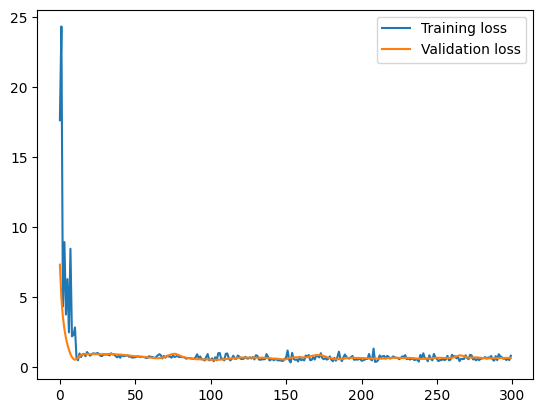

In [10]:
device = 'cuda'
epochs = 300
dataset_name = "labelme"
save_dir = f'checkpoints/{dataset_name}/'
checkpoint_path = 'checkpoints/roadlane/checkpoint.pth'
m.load_state_dict(torch.load(checkpoint_path), strict=False)
m = m.to(device)
dataloaders, dataset_size = get_train_val_dataloader(2,0, type=dataset_name)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(m.parameters(), lr=0.001)

train_dataloader = dataloaders["train"]
val_dataloader = dataloaders["val"]

print("dataset size:", dataset_size)

# TODO training loop
min_val_loss = float('inf')
train_loss = []
val_loss = []

for epoch in tqdm(range(epochs)):
    m.train()
    running_loss = 0.0
    for iter, batch in enumerate(train_dataloader):
        images = batch['img'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = m(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_train_loss  = running_loss / len(train_dataloader)

    m.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_batch in val_dataloader:
            X_val = val_batch["img"].to(device)
            y_val = val_batch["label"].to(device)
            outputs_val = m(X_val)
            running_val_loss += criterion(outputs_val, y_val).item()
    avg_val_loss = running_val_loss / len(val_dataloader)

    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_dir+'checkpoint.pth')
    
    train_loss.append(avg_train_loss)
    val_loss.append(avg_val_loss)

# Plot loss
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.savefig(save_dir+'loss.png')